In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.cuda.empty_cache()
print(f"Using device: {device}")

Using device: cuda


In [3]:
class QuadcopterEnv:
    def __init__(self):
        # Physical parameters
        self.m = 0.5  # mass in kg
        self.g = 9.81  # gravity
        self.l = 0.25  # arm length in meters
        self.Ixx = 5e-3  # moment of inertia
        self.Iyy = 5e-3
        self.Izz = 1e-2
        self.k = 3e-6   # thrust coefficient
        self.b = 1e-7   # drag coefficient
        self.kd = 0.25  # drag coefficient
        
        # Inertia matrix
        self.I = np.array([[self.Ixx, 0, 0],
                          [0, self.Iyy, 0],
                          [0, 0, self.Izz]])
        self.I_inv = np.linalg.inv(self.I)
        
    def rotation_matrix(self, angles):
        """Compute rotation matrix from euler angles (phi, theta, psi)"""
        phi, theta, psi = angles
        
        # Individual rotation matrices
        R_x = np.array([[1, 0, 0],
                       [0, np.cos(phi), -np.sin(phi)],
                       [0, np.sin(phi), np.cos(phi)]])
        
        R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                       [0, 1, 0],
                       [-np.sin(theta), 0, np.cos(theta)]])
        
        R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                       [np.sin(psi), np.cos(psi), 0],
                       [0, 0, 1]])
        
        return R_z @ R_y @ R_x
    
    def compute_forces_moments(self, state, inputs):
        """Compute forces and moments from motor inputs"""
        # Motor angular velocities (squared)
        w1, w2, w3, w4 = inputs
        
        # Total thrust
        thrust = self.k * sum(inputs)
        
        # Moments
        tau_phi = self.l * self.k * (w1 - w3)
        tau_theta = self.l * self.k * (w2 - w4)
        tau_psi = self.b * (w1 - w2 + w3 - w4)
        
        return thrust, np.array([tau_phi, tau_theta, tau_psi])
    
    def dynamics(self, state, inputs):
        """Compute state derivatives"""
        # Unpack state
        # [x, y, z, x_dot, y_dot, z_dot, phi, theta, psi, phi_dot, theta_dot, psi_dot]
        pos = state[0:3]
        vel = state[3:6]
        angles = state[6:9]
        omega = state[9:12]
        
        # Compute rotation matrix
        R = self.rotation_matrix(angles)
        
        # Compute forces and moments
        thrust, moments = self.compute_forces_moments(state, inputs)
        
        # Linear accelerations
        gravity = np.array([0, 0, -self.g])
        thrust_body = np.array([0, 0, thrust/self.m])
        acc = gravity + R @ thrust_body - self.kd/self.m * vel
        
        # Angular accelerations
        omega_skew = np.array([[0, -omega[2], omega[1]],
                              [omega[2], 0, -omega[0]],
                              [-omega[1], omega[0], 0]])
        angular_acc = self.I_inv @ (moments - omega_skew @ self.I @ omega)
        
        return np.concatenate([vel, acc, omega, angular_acc])
    def wrap_angle(self, angle):
        return ((angle + np.pi) % (2 * np.pi)) - np.pi
    
    def rk4_step(self, state, inputs, dt):
        k1 = self.dynamics(state, inputs)
        k2 = self.dynamics(state + dt/2 * k1, inputs)
        k3 = self.dynamics(state + dt/2 * k2, inputs)
        k4 = self.dynamics(state + dt * k3, inputs)
        new_state = state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        new_state[6] = self.wrap_angle(new_state[6])
        new_state[7] = self.wrap_angle(new_state[7])
        new_state[8] = self.wrap_angle(new_state[8])
        return new_state
    
    def simulate(self, initial_state, inputs_sequence, dt=0.01, steps=1000):
        """Simulate the quadcopter for multiple steps"""
        state = initial_state
        trajectory = [state]
        
        for t in range(steps):
            inputs = inputs_sequence[t] if t < len(inputs_sequence) else inputs_sequence[-1]
            state = self.rk4_step(state, inputs, dt)
            trajectory.append(state)
            
        return np.array(trajectory)

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [7]:
def create_graphs(trajectory, dt):
    time = np.arange(len(trajectory)) * dt
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, trajectory[:, 2], label='Height (z)')
    plt.plot(time, trajectory[:, 0], label='x position')
    plt.plot(time, trajectory[:, 1], label='y position')
    plt.grid(True)
    plt.legend()
    plt.title('Quadcopter Position Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    
    
    plt.subplot(2, 1, 2)
    plt.plot(time, trajectory[:, 5], label='Vertical velocity')
    plt.plot(time, trajectory[:, 3], label='x velocity')
    plt.plot(time, trajectory[:, 4], label='y velocity')
    plt.grid(True)
    plt.legend()
    plt.title('Quadcopter Velocity Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
             'b-', label='Trajectory', alpha=0.7)
    ax1.set_xlabel('X Position (m)')
    ax1.set_ylabel('Y Position (m)')
    ax1.set_zlabel('Z Position (m)')
    ax1.set_title('3D Position Trajectory')
    ax1.legend()
    
    ax1.grid(True)
    ax1.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()

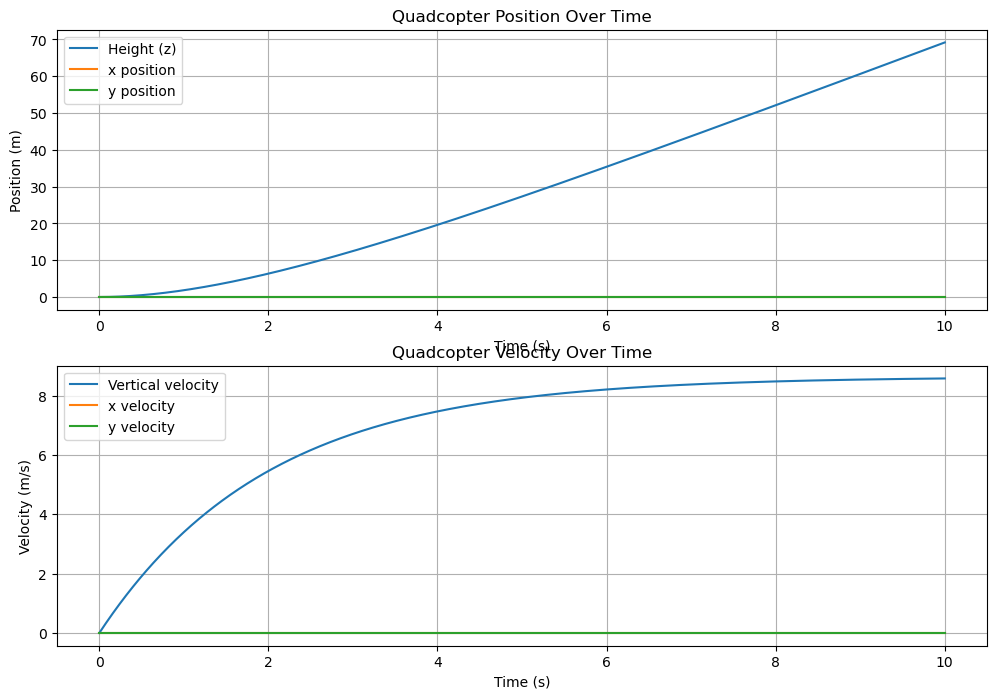

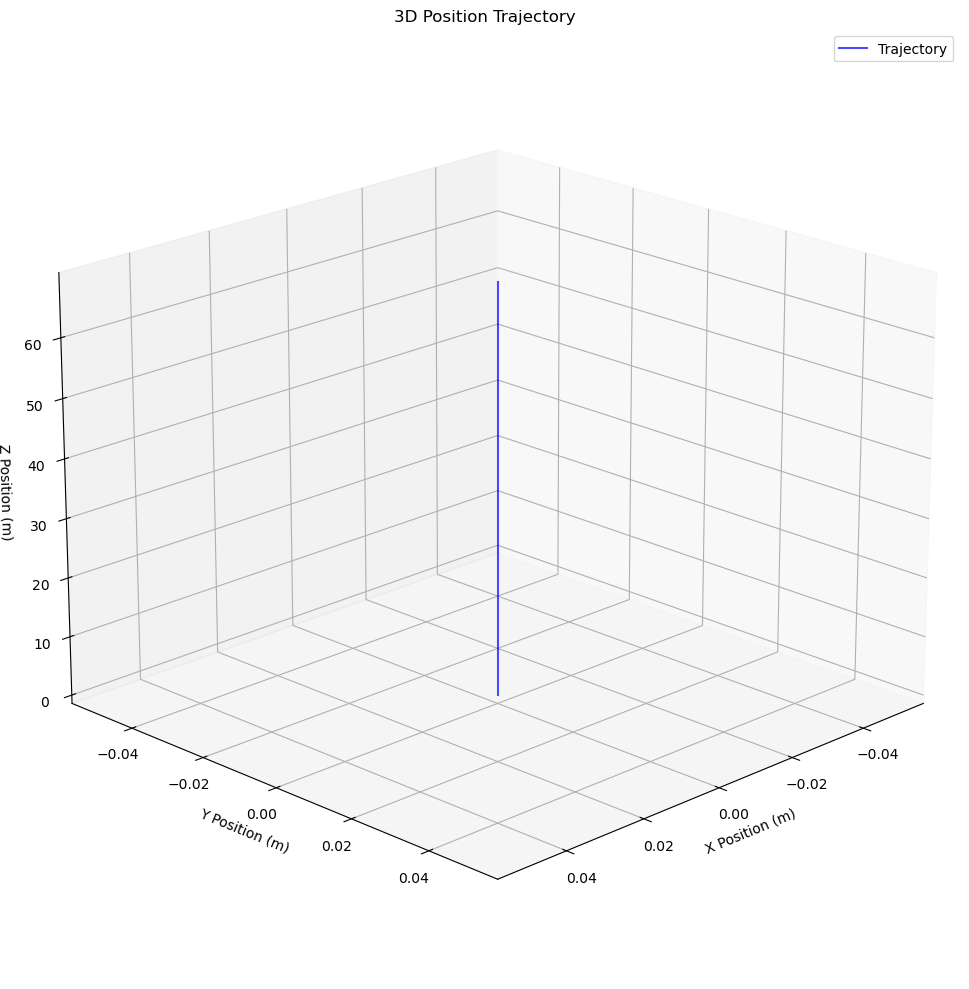

In [80]:
#Test 1 - Straight Up
env = QuadcopterEnv()
initial_state = np.zeros(12)
hover_thrust = np.sqrt(env.m * env.g / (4 * env.k))
lift_thrust = hover_thrust * 1.2
constant_input = np.array([lift_thrust**2, lift_thrust**2, lift_thrust**2, lift_thrust**2])
inputs_sequence = [constant_input] * 1000 
dt = 0.01
trajectory = env.simulate(initial_state, inputs_sequence, dt=dt)
create_graphs(trajectory, dt)

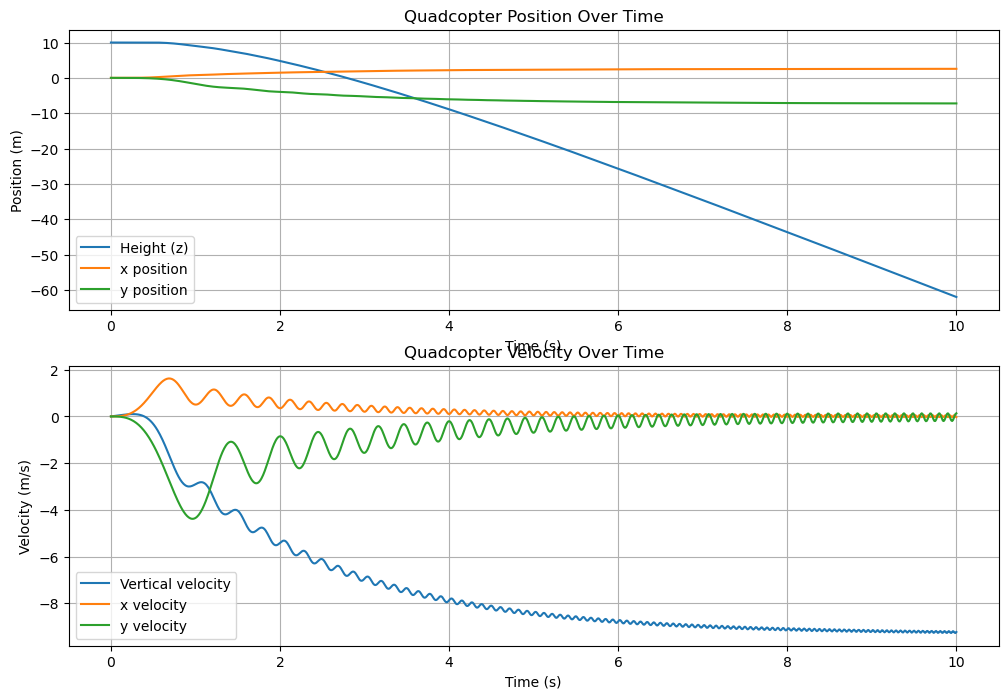

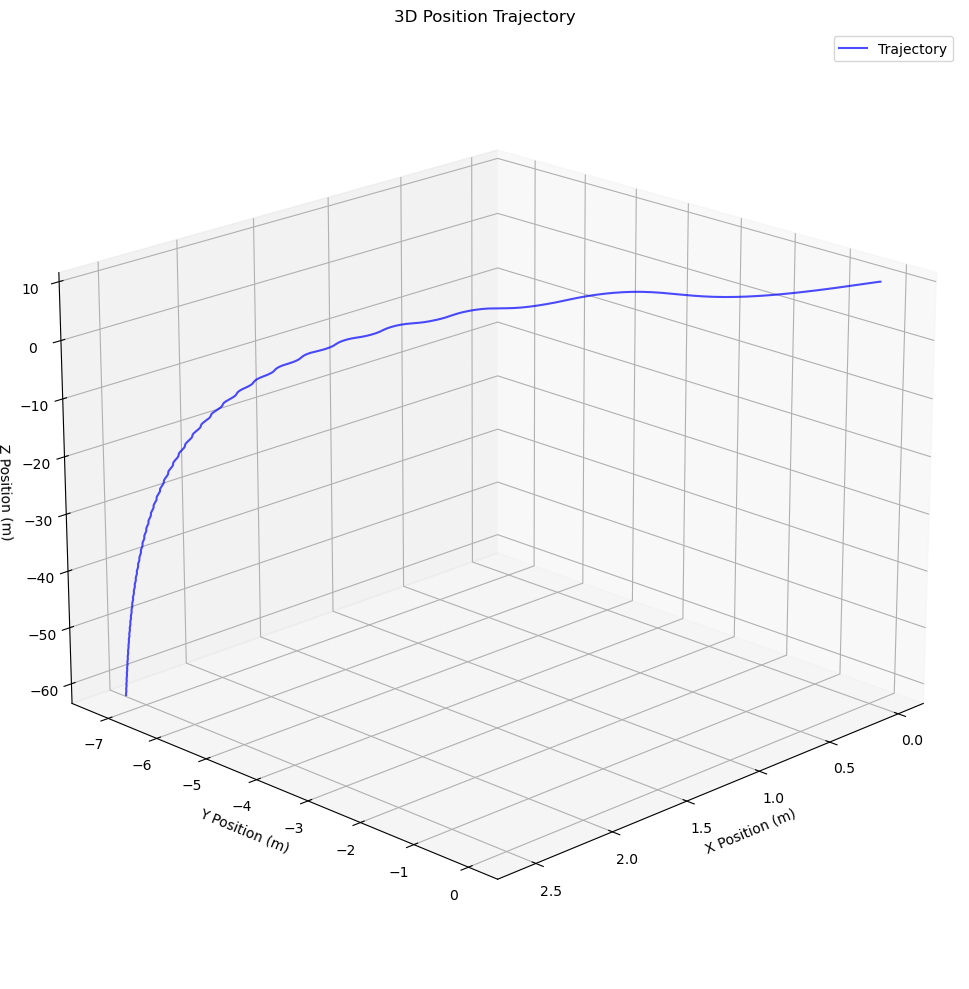

In [17]:
#Test 2 - Add Force to motor 1 and 2 - should move in one direction
env = QuadcopterEnv()
initial_state = np.zeros(12)
initial_state[2] = 10.0 # initial hieght is 10
hover_thrust = np.sqrt(env.m * env.g / (4 * env.k))
lift_thrust = hover_thrust
added_force = lift_thrust + hover_thrust * 0.05
constant_input = np.array([added_force**2, added_force**2, lift_thrust**2, lift_thrust**2])
inputs_sequence = [constant_input] * 1000 
dt = 0.01
trajectory = env.simulate(initial_state, inputs_sequence, dt=dt)
time = np.arange(len(trajectory)) * dt
create_graphs(trajectory, dt)

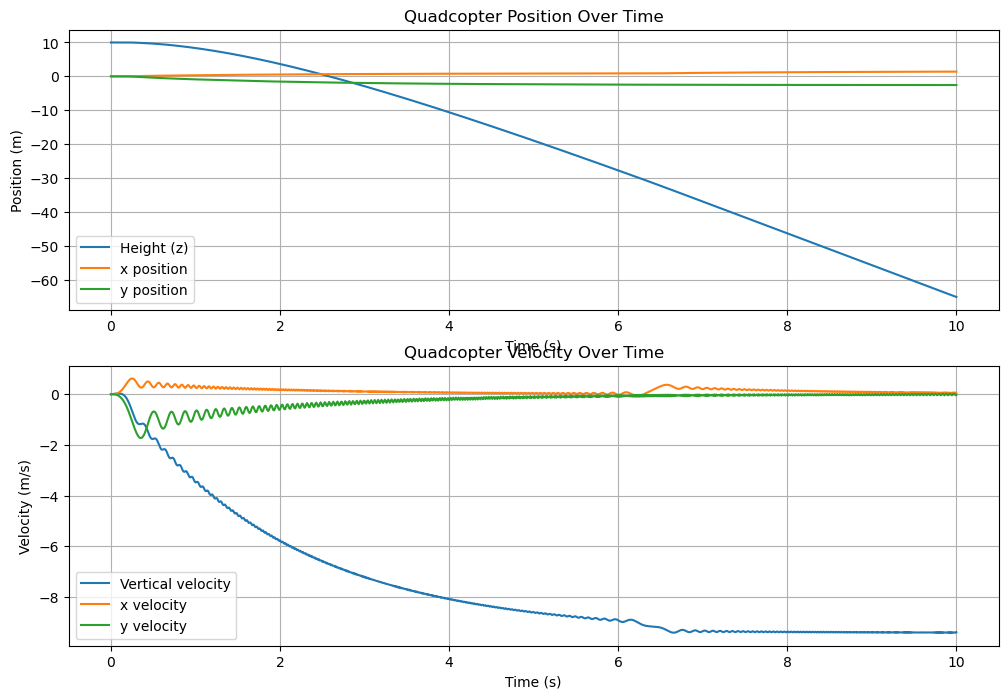

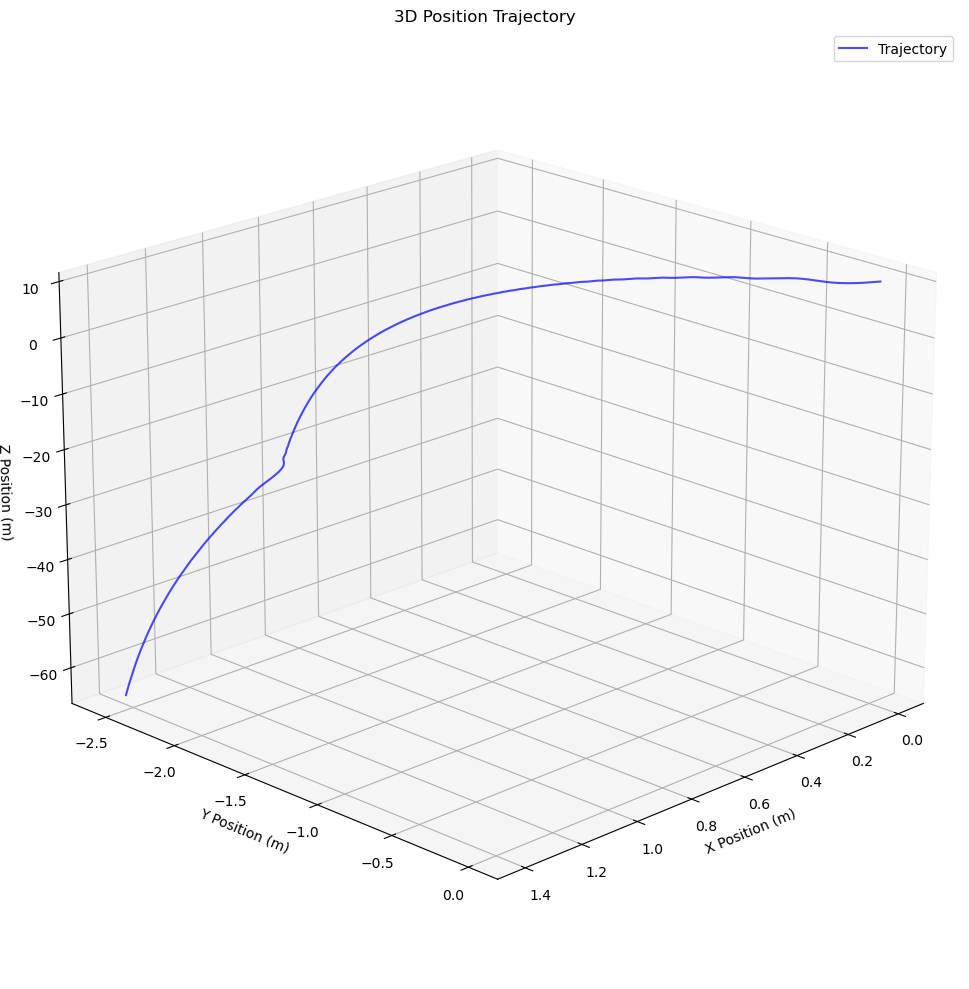

<Figure size 640x480 with 0 Axes>

In [19]:
#Test 2 - Add Force to motor 1 and 2 and remove from 3 and 4- should move in one direction(stable)
env = QuadcopterEnv()
initial_state = np.zeros(12)
initial_state[2] = 10.0 # initial hieght is 10
hover_thrust = np.sqrt(env.m * env.g / (4 * env.k))
lift_thrust = hover_thrust
added_force = lift_thrust + hover_thrust * 0.2
less_force = lift_thrust - hover_thrust * 0.2
constant_input = np.array([added_force**2, added_force**2, less_force**2, less_force**2])
inputs_sequence = [constant_input] * 1000 
dt = 0.01
trajectory = env.simulate(initial_state, inputs_sequence, dt=dt)
time = np.arange(len(trajectory)) * dt
create_graphs(trajectory, dt)
save_folder = "quadcopter-tests"
os.makedirs(save_folder, exist_ok=True)

plt.savefig(os.path.join(save_folder, 'quadcopter_test_1.png'), 
            dpi=300, bbox_inches='tight')

In [52]:
#Test 3 - Gimbal Lock
env = QuadcopterEnv()
initial_state = np.zeros(12)
hover_thrust = np.sqrt(env.m * env.g / (4 * env.k))
lift_thrust = hover_thrust
constant_input = np.array([lift_thrust**2, lift_thrust**2, lift_thrust**2, lift_thrust**2])
inputs_sequence = [constant_input] * 1000 
dt = 0.01
trajectory = env.simulate(initial_state, inputs_sequence, dt=dt)


In [70]:
import numpy as np

def test_rotations(quad):
    # Create test states with different combinations of angles
    test_cases = [
        # [phi (roll), theta (pitch), psi (yaw)]
        [0, np.pi/2, 0],      # 90 degree pitch
        [0, np.pi/2, np.pi/4], # 90 degree pitch with 45 degree yaw
        [np.pi/4, np.pi/2, 0], # 90 degree pitch with 45 degree roll
        [0, np.pi/2 - 0.01, np.pi/2]  # Near 90 degree pitch with 90 degree yaw
    ]

    for angles in test_cases:
        # Create a state vector with these angles
        state = np.zeros(12)
        state[6:9] = angles  # Set the angles
        
        # Get rotation matrix
        R = quad.rotation_matrix(angles)
        
        # Apply small angular velocities
        omega = np.array([0.1, 0.1, 0.1])  # Small angular rates
        state[9:12] = omega
        
        # Simulate one step
        dt = 0.01
        inputs = np.array([1500, 1500, 1500, 1500])  # Hover thrust
        new_state = quad.rk4_step(state, inputs, dt)
        
        print(f"\nTest case: phi={angles[0]*180/np.pi:.1f}°, theta={angles[1]*180/np.pi:.1f}°, psi={angles[2]*180/np.pi:.1f}°")
        print("Original angles (deg):", np.array(angles) * 180/np.pi)
        print("New angles (deg):", new_state[6:9] * 180/np.pi)
        print("Angular rates (deg/s):", new_state[9:12] * 180/np.pi)

# Run the test
env = QuadcopterEnv()
test_rotations(env)


Test case: phi=0.0°, theta=90.0°, psi=0.0°
Original angles (deg): [ 0. 90.  0.]
New angles (deg): [5.72671221e-02 9.00573244e+01 5.72957795e-02]
Angular rates (deg/s): [5.72384551 5.73530466 5.72957795]

Test case: phi=0.0°, theta=90.0°, psi=45.0°
Original angles (deg): [ 0. 90. 45.]
New angles (deg): [5.72671221e-02 9.00573244e+01 4.50572958e+01]
Angular rates (deg/s): [5.72384551 5.73530466 5.72957795]

Test case: phi=45.0°, theta=90.0°, psi=0.0°
Original angles (deg): [45. 90.  0.]
New angles (deg): [4.50572671e+01 9.00573244e+01 5.72957795e-02]
Angular rates (deg/s): [5.72384551 5.73530466 5.72957795]

Test case: phi=0.0°, theta=89.4°, psi=90.0°
Original angles (deg): [ 0.        89.4270422 90.       ]
New angles (deg): [5.72671221e-02 8.94843666e+01 9.00572958e+01]
Angular rates (deg/s): [5.72384551 5.73530466 5.72957795]


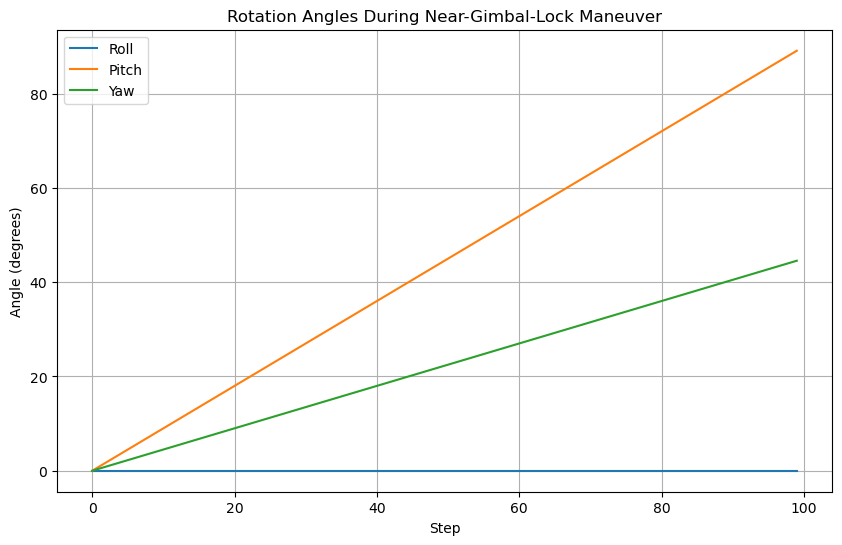

In [72]:
def test_rotation_sequence(quad):
    # Create a trajectory that should highlight gimbal lock
    steps = 100
    trajectory = []
    state = np.zeros(12)
    
    # Gradually increase pitch to 90 degrees while yawing
    for i in range(steps):
        state[7] = (np.pi/2) * (i/steps)  # Pitch
        state[8] = (np.pi/4) * (i/steps)  # Yaw
        trajectory.append(state.copy())
        
    # Plot the angles
    angles = np.array([s[6:9] for s in trajectory]) * 180/np.pi
    time = np.arange(steps)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(time, angles[:, 0], label='Roll')
    plt.plot(time, angles[:, 1], label='Pitch')
    plt.plot(time, angles[:, 2], label='Yaw')
    plt.xlabel('Step')
    plt.ylabel('Angle (degrees)')
    plt.title('Rotation Angles During Near-Gimbal-Lock Maneuver')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the visualization
test_rotation_sequence(env)